In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lightgbm as lgb

import warnings
# Code was showing some warnings, from stack overflow optimal answer was to include this
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df= pd.read_csv("fetal_health.csv")

In [3]:
X = df.iloc[:, :-1]  
y = df.iloc[:, -1]   


## Before Normalization

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
lgb_classifier = lgb.LGBMClassifier()

lgb_classifier.fit(X_train, y_train)
y_pred = lgb_classifier.predict(X_test)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1208
[LightGBM] [Info] Number of data points in the train set: 1700, number of used features: 20
[LightGBM] [Info] Start training from score -0.251483
[LightGBM] [Info] Start training from score -1.995966
[LightGBM] [Info] Start training from score -2.447951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Calculating using average micro
print("Accuracy = ", accuracy_score(y_test, y_pred) * 100, "%")
print("Precision = ", precision_score(y_test, y_pred,average='micro'))
print("Recall = ", recall_score(y_test, y_pred,average='micro'))
print("F1-score = ", f1_score(y_test, y_pred,average='micro'))
print("Confusion Matrix = ")
print(confusion_matrix(y_test, y_pred))
print ("********")
# Using classification report too
print("Classification Report")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


Accuracy =  95.77464788732394 %
Precision =  0.9577464788732394
Recall =  0.9577464788732394
F1-score =  0.9577464788732394
Confusion Matrix = 
[[327   6   0]
 [ 10  54   0]
 [  1   1  27]]
********
Classification Report
              precision    recall  f1-score   support

         1.0       0.97      0.98      0.97       333
         2.0       0.89      0.84      0.86        64
         3.0       1.00      0.93      0.96        29

    accuracy                           0.96       426
   macro avg       0.95      0.92      0.93       426
weighted avg       0.96      0.96      0.96       426



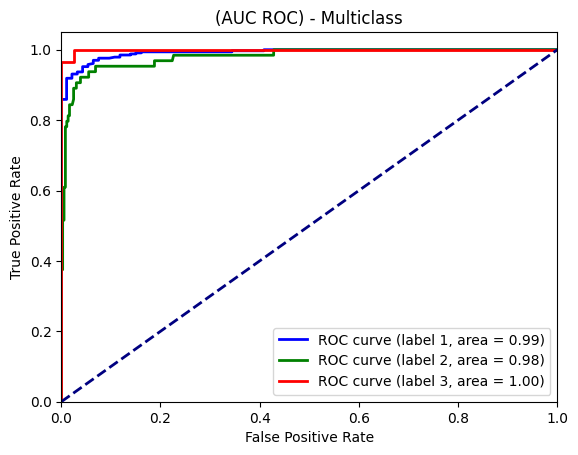

In [7]:
# For multiclass

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize



y_test_binarized = label_binarize(y_test, classes=[1, 2, 3])
y_scores = lgb_classifier.predict_proba(X_test)
plt.figure()

n_classes = 3
colors = ['b', 'g', 'r']

for i in range(1, n_classes + 1):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i - 1], y_scores[:, i - 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i - 1], lw=2, label=f'ROC curve (label {i}, area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(AUC ROC) - Multiclass')
plt.legend(loc="lower right")
plt.show()


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 170, number of used features: 19
[LightGBM] [Info] Start training from score -1.498212
[LightGBM] [Info] Start training from score -0.356675
[LightGBM] [Info] Start training from score -2.570849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

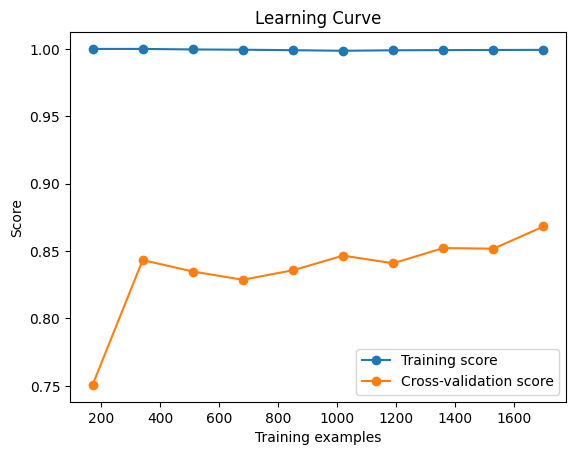

In [8]:
train_sizes, train_scores, test_scores = learning_curve(lgb_classifier, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

In [9]:
# data set had negative value, using log transform to make positive and Adding 1 in X, to prevent log value as infinite

X_log_transformed = np.log1p(X + 1)

kbest = SelectKBest(score_func=chi2, k=5)
X_new = kbest.fit_transform(X_log_transformed, y)


In [10]:
feature_scores = kbest.scores_
print("Feature Importance Scores:")
print(feature_scores)

Feature Importance Scores:
[2.61919200e-01 1.77368755e-03 1.52940324e-02 5.36050691e-04
 3.95730127e-04 6.56463269e-08 8.59609816e-05 1.68957195e+01
 1.45339333e+01 5.29494011e+02 4.23579355e+01 1.72531418e+01
 3.22287127e+00 1.27957858e-02 5.13797999e+00 5.46795895e-01
 1.72059243e+00 1.58334943e+00 1.05026330e+00 1.21194002e+02
 1.18517227e+01]


## After Normalization

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_normalized = scaler.fit_transform(X)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)


In [13]:

lgb_classifier_after = lgb.LGBMClassifier()

lgb_classifier_after.fit(X_train, y_train)
y_pred_after = lgb_classifier_after.predict(X_test)



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1202
[LightGBM] [Info] Number of data points in the train set: 1700, number of used features: 20
[LightGBM] [Info] Start training from score -0.251483
[LightGBM] [Info] Start training from score -1.995966
[LightGBM] [Info] Start training from score -2.447951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Calculating using average micro
print("Accuracy = ", accuracy_score(y_test, y_pred_after) * 100, "%")
print("Precision = ", precision_score(y_test, y_pred_after,average='micro'))
print("Recall = ", recall_score(y_test, y_pred_after,average='micro'))
print("F1-score = ", f1_score(y_test, y_pred_after,average='micro'))
print("Confusion Matrix = ")
print(confusion_matrix(y_test, y_pred_after))
print ("********")
# Using classification report too
print("Classification Report")
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_after))


Accuracy =  95.77464788732394 %
Precision =  0.9577464788732394
Recall =  0.9577464788732394
F1-score =  0.9577464788732394
Confusion Matrix = 
[[327   6   0]
 [ 10  54   0]
 [  1   1  27]]
********
Classification Report
              precision    recall  f1-score   support

         1.0       0.97      0.98      0.97       333
         2.0       0.89      0.84      0.86        64
         3.0       1.00      0.93      0.96        29

    accuracy                           0.96       426
   macro avg       0.95      0.92      0.93       426
weighted avg       0.96      0.96      0.96       426



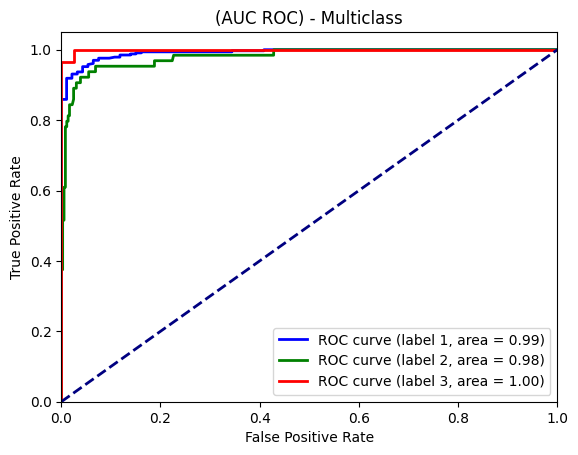

In [15]:
# For multiclass

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_test_binarized = label_binarize(y_test, classes=[1, 2, 3])
y_scores = lgb_classifier_after.predict_proba(X_test)

plt.figure()

n_classes = 3
colors = ['b', 'g', 'r']

for i in range(1, n_classes + 1):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i - 1], y_scores[:, i - 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i - 1], lw=2, label=f'ROC curve (label {i}, area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('(AUC ROC) - Multiclass')
plt.legend(loc="lower right")
plt.show()


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 444
[LightGBM] [Info] Number of data points in the train set: 170, number of used features: 19
[LightGBM] [Info] Start training from score -1.498212
[LightGBM] [Info] Start training from score -0.356675
[LightGBM] [Info] Start training from score -2.570849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

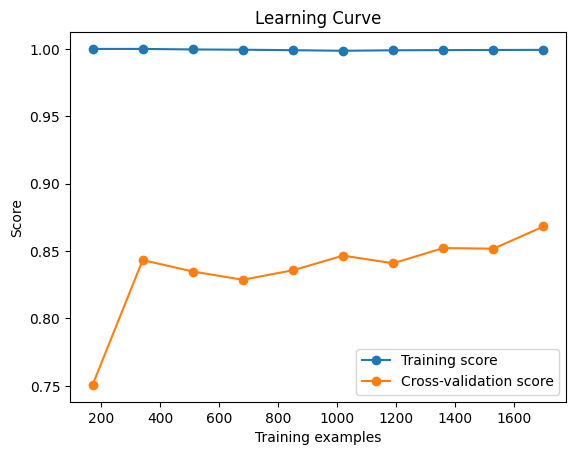

In [16]:
train_sizes, train_scores, test_scores = learning_curve(lgb_classifier_after, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

In [17]:
# data set had negative value, using log transform to make positive and Adding 1 in X, to prevent log value as infinite

X_log_transformed = np.log1p(X + 1)

kbest = SelectKBest(score_func=chi2, k=5)
X_new = kbest.fit_transform(X_log_transformed, y)


In [18]:
feature_scores = kbest.scores_
print("Feature Importance Scores:")
print(feature_scores)

Feature Importance Scores:
[2.61919200e-01 1.77368755e-03 1.52940324e-02 5.36050691e-04
 3.95730127e-04 6.56463269e-08 8.59609816e-05 1.68957195e+01
 1.45339333e+01 5.29494011e+02 4.23579355e+01 1.72531418e+01
 3.22287127e+00 1.27957858e-02 5.13797999e+00 5.46795895e-01
 1.72059243e+00 1.58334943e+00 1.05026330e+00 1.21194002e+02
 1.18517227e+01]
